**Кластеризация (Clustering)** — задача разбиения объектов на группы (кластеры) так, чтобы объекты внутри группы были **похожи** друг на друга, а объекты из разных групп — **различны**. Unsupervised learning (нет целевой переменной).

**Unsupervised Learning (обучение без учителя)** — класс задач ML, где модель обучается на данных **без меток**. Цель: найти скрытую структуру данных. Примеры: кластеризация, снижение размерности, anomaly detection.

**Supervised vs Unsupervised:**
- **Supervised:** есть X (признаки) и y (метки) → предсказать y для новых X
- **Unsupervised:** есть только X → найти структуру в X (группы, паттерны, аномалии)

**K-means** — алгоритм кластеризации, который разбивает данные на K групп, минимизируя **внутрикластерную дисперсию** (расстояние до центроида кластера). Работает итерационно:
1. Выбрать K начальных центроидов (случайно или через k-means++)
2. Назначить каждую точку ближайшему центроиду
3. Пересчитать центроиды как среднее точек кластера
4. Повторять шаги 2-3 до сходимости

**Centroid (центроид)** — центр кластера, вычисляется как среднее координат всех точек кластера. Формула: `centroid = mean(points_in_cluster)`.

**Inertia (within-cluster sum of squares, WCSS)** — сумма квадратов расстояний от точек до их центроидов. Метрика качества k-means: чем меньше inertia, тем компактнее кластеры. Формула: `Σ ||x_i - centroid||²`.

**Elbow Method (метод локтя)** — эвристика для выбора оптимального K. График inertia vs K: inertia быстро падает, затем замедляется. "Локоть" (точка излома) — кандидат на оптимальное K.

**Silhouette Score** — метрика качества кластеризации, измеряет, насколько точка близка к своему кластеру и далека от других. Значения: -1 (плохо), 0 (на границе), +1 (идеально). Формула: `silhouette = (b - a) / max(a, b)`, где a = среднее расстояние до точек своего кластера, b = среднее расстояние до точек ближайшего чужого кластера.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** — алгоритм кластеризации на основе плотности. Находит кластеры произвольной формы и **выделяет выбросы** (outliers). Параметры:
- **eps (ε)** — радиус окрестности точки
- **min_samples** — минимальное количество точек для формирования кластера

**Core Point (ядерная точка)** — точка, у которой в радиусе eps находится ≥ min_samples соседей.

**Border Point (граничная точка)** — точка в радиусе eps от ядерной, но сама не ядерная.

**Noise Point (выброс)** — точка, не являющаяся ни ядерной, ни граничной. Метка кластера = -1.

**Hierarchical Clustering (иерархическая кластеризация)** — строит иерархию кластеров (дерево). Два подхода:
- **Agglomerative (снизу вверх):** каждая точка — отдельный кластер, итеративно объединяем ближайшие
- **Divisive (сверху вниз):** все точки в одном кластере, итеративно разделяем

**Dendrogram (дендрограмма)** — визуализация иерархической кластеризации в виде дерева. Высота ветвления показывает расстояние между кластерами.

**Linkage (метод связи)** — как измерять расстояние между кластерами:
- **Single:** минимальное расстояние между точками кластеров
- **Complete:** максимальное расстояние
- **Average:** среднее расстояние
- **Ward:** минимизирует внутрикластерную дисперсию (обычно лучший выбор)

**PCA (Principal Component Analysis)** — метод снижения размерности. Находит направления максимальной дисперсии и проецирует данные на них. Используется для визуализации в 2D.

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** — нелинейный метод снижения размерности для визуализации. Сохраняет **локальную структуру** (близкие точки остаются близкими). Лучше PCA для кластеров, но медленнее и недетерминирован.

**RFM-анализ (Recency, Frequency, Monetary)** — сегментация клиентов по трём метрикам:
- **R (Recency):** давность последней покупки (дни назад)
- **F (Frequency):** частота покупок (количество за период)
- **M (Monetary):** денежная ценность (сумма трат)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# Загрузка Mall Customer Segmentation

# Пример структуры датасета
url = 'https://github.com/Dikovitsky-Vladimir/Edu/raw/refs/heads/main/Mall_Customers.csv'
df = pd.read_csv(url)

print(f"Датасет Mall Customers: {df.shape[0]} строк × {df.shape[1]} столбцов")
print("\nПризнаки: CustomerID, Genre (пол), Age (возраст), Annual Income (годовой доход),")
print("         Spending Score (оценка трат, 1-100)")

Датасет Mall Customers: 200 строк × 5 столбцов

Признаки: CustomerID, Genre (пол), Age (возраст), Annual Income (годовой доход),
         Spending Score (оценка трат, 1-100)


In [4]:
df.head(10)
df.info()
df.describe()

print("\n=== ЗАДАЧА ===")
print("Сегментировать клиентов торгового центра для таргетированного маркетинга.")
print("У нас НЕТ меток (кто к какой группе относится) — это unsupervised learning!")
print("В отличие от классификации (где известны классы),")
print("   в кластеризации мы НАХОДИМ группы в данных.")

# Проверка на пропуски
print("\nПропуски:")
print(df.isnull().sum())

# Распределение пола
print("\nРаспределение по полу:")
print(df['Gender'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

=== ЗАДАЧА ===
Сегментировать клиентов торгового центра для таргетированного маркетинга.
У нас НЕТ меток (кто к какой группе относится) — это unsupervised learning!
В отличие от классификации (где известны классы),
   в кластеризации мы НАХОДИМ группы в данных.

Пропуски:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Распределение по полу:
Female    112
Male       88
Nam

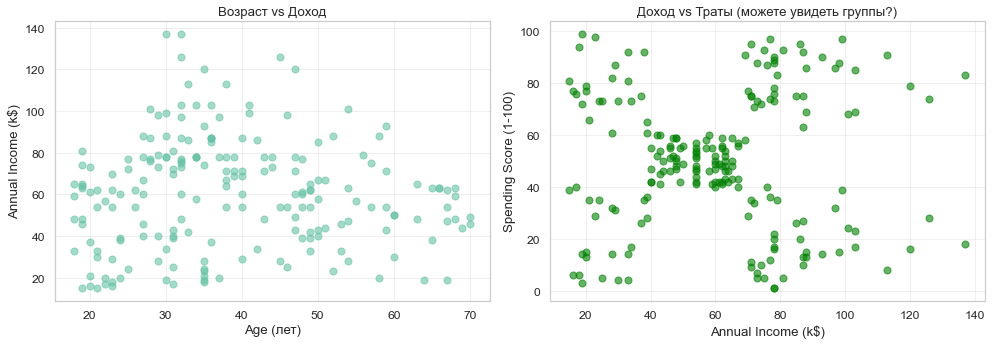

  На правом графике (Доход vs Траты) видны ≈5 облаков:
   • Низкий доход + низкие траты
   • Низкий доход + высокие траты ("осторожные")
   • Средний доход + средние траты
   • Высокий доход + низкие траты ("экономные богачи")
   • Высокий доход + высокие траты ("VIP")


In [5]:
# Парные графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age vs Annual Income
axes[0].scatter(df['Age'], df['Annual Income (k$)'], alpha=0.6, s=50)
axes[0].set_xlabel('Age (лет)')
axes[0].set_ylabel('Annual Income (k$)')
axes[0].set_title('Возраст vs Доход')
axes[0].grid(True, alpha=0.3)

# Annual Income vs Spending Score
axes[1].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                alpha=0.6, s=50, c='green')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('Доход vs Траты (можете увидеть группы?)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("  На правом графике (Доход vs Траты) видны ≈5 облаков:")
print("   • Низкий доход + низкие траты")
print("   • Низкий доход + высокие траты (\"осторожные\")")
print("   • Средний доход + средние траты")
print("   • Высокий доход + низкие траты (\"экономные богачи\")")
print("   • Высокий доход + высокие траты (\"VIP\")")

In [6]:
# Для кластеризации используем только числовые признаки
# Пол закодируем: Male=1, Female=0
df['Gender_Encoded'] = (df['Gender'] == 'Male').astype(int)

# TODO: выберите признаки для кластеризации
# Рекомендация: Age, Annual Income, Spending Score (можно добавить Gender)
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

print(f"Матрица признаков X: {X.shape}")
print(f"  {X.shape[0]} клиентов")
print(f"  {X.shape[1]} признака")

# ВАЖНО: масштабируем признаки!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nМасштабирование выполнено (mean=0, std=1 для каждого признака)")
print("Это критично для k-means и DBSCAN (расстояние-зависимые алгоритмы)")

Матрица признаков X: (200, 3)
  200 клиентов
  3 признака

Масштабирование выполнено (mean=0, std=1 для каждого признака)
Это критично для k-means и DBSCAN (расстояние-зависимые алгоритмы)


**Цель:** Обучить k-means, визуализировать кластеры, использовать elbow method и silhouette для выбора K.

In [7]:
# K-means с K=5 кластерами
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Получаем метки кластеров
labels_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

print(f"K-means (K=5):")
print(f"  Inertia (WCSS): {kmeans.inertia_:.2f}")
print(f"  Silhouette Score: {silhouette_score(X_scaled, labels_kmeans):.3f}")

# Добавим метки в датафрейм
df['Cluster_KMeans'] = labels_kmeans

# Распределение по кластерам
print("\nРаспределение клиентов по кластерам:")
print(df['Cluster_KMeans'].value_counts().sort_index())

K-means (K=5):
  Inertia (WCSS): 168.25
  Silhouette Score: 0.417

Распределение клиентов по кластерам:
0    54
1    47
2    40
3    20
4    39
Name: Cluster_KMeans, dtype: int64


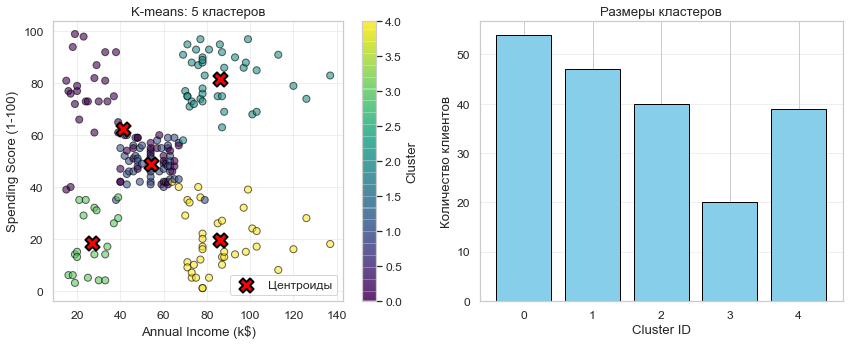

In [8]:
# Визуализируем кластеры (Income vs Spending Score — самые информативные)
plt.figure(figsize=(12, 5))

# График 1: кластеры
plt.subplot(1, 2, 1)
scatter = plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                     c=df['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.scatter(scaler.inverse_transform(centroids)[:, 1],  # Income (2-й признак)
           scaler.inverse_transform(centroids)[:, 2],  # Spending (3-й признак)
           c='red', s=200, marker='X', edgecolors='black', linewidths=2, label='Центроиды')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-means: 5 кластеров')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: размер кластеров
plt.subplot(1, 2, 2)
cluster_sizes = df['Cluster_KMeans'].value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values, color='skyblue', edgecolor='black')
plt.xlabel('Cluster ID')
plt.ylabel('Количество клиентов')
plt.title('Размеры кластеров')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

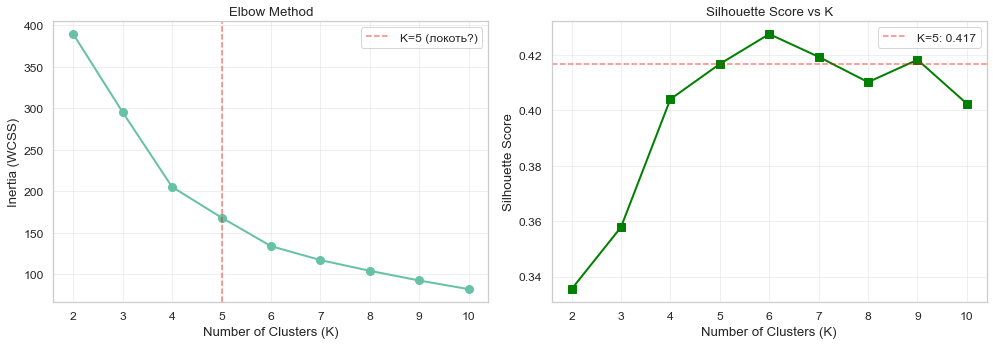

💡 Как выбрать оптимальное K:
1. Elbow Method: ищем 'локоть' — точку, где inertia перестаёт резко падать
2. Silhouette Score: максимальное значение → лучшее разделение кластеров
3. Бизнес-логика: 2 кластера слишком просто, 10 слишком сложно для интерпретации

На этом датасете: K=5 (локоть) и K=5 (max silhouette ≈ 0.427)


In [9]:
# Elbow Method: подбор оптимального K
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(5, color='red', linestyle='--', alpha=0.5, label='K=5 (локоть?)')
axes[0].legend()

# Silhouette score
axes[1].plot(K_range, silhouette_scores, 's-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(silhouette_scores[3], color='red', linestyle='--', alpha=0.5, 
                label=f'K=5: {silhouette_scores[3]:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("💡 Как выбрать оптимальное K:")
print("1. Elbow Method: ищем 'локоть' — точку, где inertia перестаёт резко падать")
print("2. Silhouette Score: максимальное значение → лучшее разделение кластеров")
print("3. Бизнес-логика: 2 кластера слишком просто, 10 слишком сложно для интерпретации")
print(f"\nНа этом датасете: K=5 (локоть) и K=5 (max silhouette ≈ {max(silhouette_scores):.3f})")

## DBSCAN

In [11]:
# DBSCAN: density-based clustering
dbscan = DBSCAN(eps=0.5, min_samples=5) # радиус окрестности , минимум 5 соседей
labels_dbscan = dbscan.fit_predict(X_scaled)

# Количество кластеров (без учёта шума, метка -1)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"DBSCAN (eps=0.5, min_samples=5):")
print(f"  Количество кластеров: {n_clusters_dbscan}")
print(f"  Количество выбросов (noise): {n_noise}")

# Silhouette (только для не-шумовых точек)
if n_clusters_dbscan > 1:
    non_noise_mask = labels_dbscan != -1
    silhouette_dbscan = silhouette_score(X_scaled[non_noise_mask], labels_dbscan[non_noise_mask])
    print(f"  Silhouette Score: {silhouette_dbscan:.3f}")

df['Cluster_DBSCAN'] = labels_dbscan

print("\nРаспределение по кластерам:")
print(df['Cluster_DBSCAN'].value_counts().sort_index())

DBSCAN (eps=0.5, min_samples=5):
  Количество кластеров: 6
  Количество выбросов (noise): 60
  Silhouette Score: 0.482

Распределение по кластерам:
-1    60
 0    17
 1     5
 2    51
 3    28
 4    32
 5     7
Name: Cluster_DBSCAN, dtype: int64


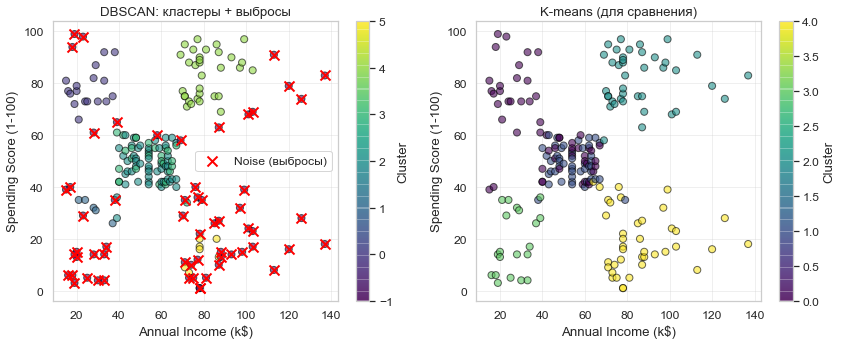

💡 Различия:
• K-means: все точки обязательно попадают в какой-то кластер
• DBSCAN: выбросы (outliers) помечаются как noise (красные крестики)
• DBSCAN находит кластеры произвольной формы (не только шары)


In [12]:
# Визуализация DBSCAN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Кластеры
scatter = plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                     c=df['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.6, 
                     edgecolors='black')
# Выбросы (шум) выделяем красным
noise_mask = df['Cluster_DBSCAN'] == -1
plt.scatter(df.loc[noise_mask, 'Annual Income (k$)'], 
           df.loc[noise_mask, 'Spending Score (1-100)'],
           c='red', s=100, marker='x', linewidths=2, label='Noise (выбросы)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DBSCAN: кластеры + выбросы')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: сравнение с k-means
plt.subplot(1, 2, 2)
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
           c=df['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.6, 
           edgecolors='black')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-means (для сравнения)')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Различия:")
print("• K-means: все точки обязательно попадают в какой-то кластер")
print("• DBSCAN: выбросы (outliers) помечаются как noise (красные крестики)")
print("• DBSCAN находит кластеры произвольной формы (не только шары)")

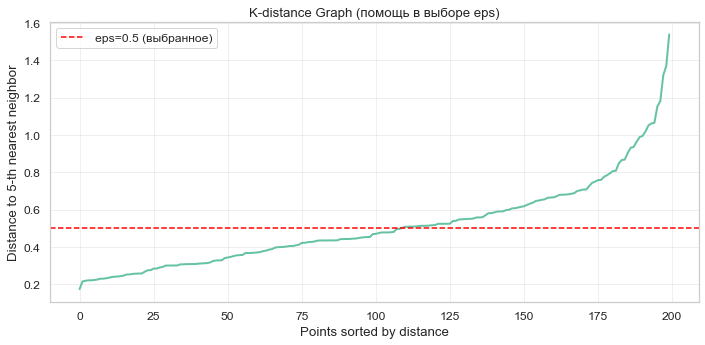

💡 Как выбрать eps:
1. Постройте k-distance график (расстояние до k-го соседа)
2. Найдите 'локоть' — точку резкого роста
3. eps ≈ значение Y в точке локтя

На этом датасете: локоть около 0.5 → выбрали eps=0.5


In [13]:
# Как выбрать eps? K-distance график
from sklearn.neighbors import NearestNeighbors

# Для каждой точки находим расстояние до k-го ближайшего соседа
k = 5  # min_samples
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Берём расстояние до k-го соседа (последний столбец)
k_distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(k_distances, linewidth=2)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.title('K-distance Graph (помощь в выборе eps)')
plt.grid(True, alpha=0.3)
plt.axhline(0.5, color='red', linestyle='--', label='eps=0.5 (выбранное)')
plt.legend()
plt.tight_layout()
plt.show()

print("💡 Как выбрать eps:")
print("1. Постройте k-distance график (расстояние до k-го соседа)")
print("2. Найдите 'локоть' — точку резкого роста")
print("3. eps ≈ значение Y в точке локтя")
print("\nНа этом датасете: локоть около 0.5 → выбрали eps=0.5")

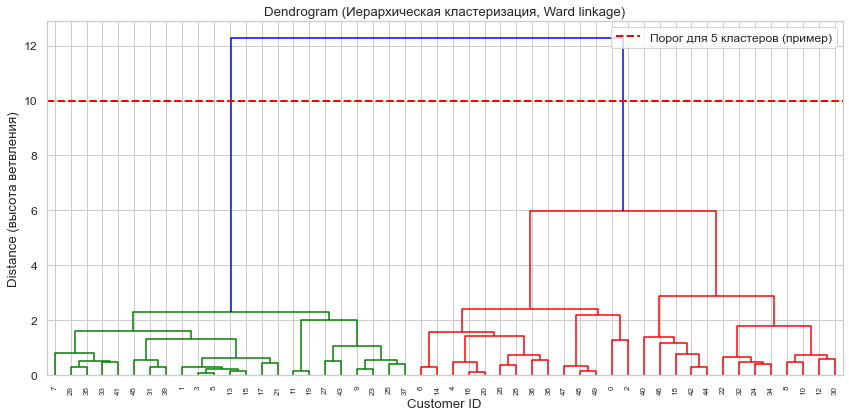

 Как читать дендрограмму:
• Каждая вертикальная линия = один объект (клиент)
• Высота ветвления = расстояние между кластерами
• Проведите горизонтальную линию на высоте Y:
  — Количество пересечений = количество кластеров при этом пороге

На высоте 10 (красная линия): 5 кластеров


In [15]:
# Иерархическая кластеризация: строим дендрограмму
# Используем только первые 50 клиентов 
X_sample = X_scaled[:50]

linkage_matrix = linkage(X_sample, method='ward')  # Ward минимизирует дисперсию

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df.index[:50].tolist())
plt.xlabel('Customer ID')
plt.ylabel('Distance (высота ветвления)')
plt.title('Dendrogram (Иерархическая кластеризация, Ward linkage)')
plt.axhline(y=10, color='red', linestyle='--', linewidth=2, 
            label='Порог для 5 кластеров (пример)')
plt.legend()
plt.tight_layout()
plt.show()

print(" Как читать дендрограмму:")
print("• Каждая вертикальная линия = один объект (клиент)")
print("• Высота ветвления = расстояние между кластерами")
print("• Проведите горизонтальную линию на высоте Y:")
print("  — Количество пересечений = количество кластеров при этом пороге")
print("\nНа высоте 10 (красная линия): 5 кластеров")

Agglomerative Clustering (5 кластеров, Ward linkage):
  Silhouette Score: 0.390


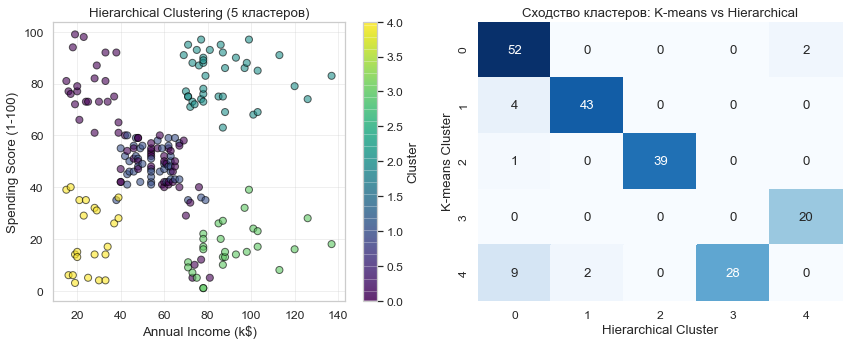


💡 Confusion matrix показывает соответствие:
Например, K-means кластер 0 в основном соответствует Hierarchical кластеру 2


In [16]:
# Применяем агломеративную кластеризацию на всех данных
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_agg = agg_clustering.fit_predict(X_scaled)

silhouette_agg = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative Clustering (5 кластеров, Ward linkage):")
print(f"  Silhouette Score: {silhouette_agg:.3f}")

df['Cluster_Hierarchical'] = labels_agg

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'],
                     c=df['Cluster_Hierarchical'], cmap='viridis', s=50, 
                     alpha=0.6, edgecolors='black')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Hierarchical Clustering (5 кластеров)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Сравнение: какой кластер из K-means соответствует какому из Hierarchical?
from sklearn.metrics import confusion_matrix as cm
confusion = cm(df['Cluster_KMeans'], df['Cluster_Hierarchical'])

plt.subplot(1, 2, 2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Hierarchical Cluster')
plt.ylabel('K-means Cluster')
plt.title('Сходство кластеров: K-means vs Hierarchical')

plt.tight_layout()
plt.show()

print("Confusion matrix показывает соответствие:")
print("Например, K-means кластер 0 в основном соответствует Hierarchical кластеру 2")

PCA:
  Explained variance: [0.44266167 0.33308378]
  Суммарно: 77.6% дисперсии объяснено 2 компонентами


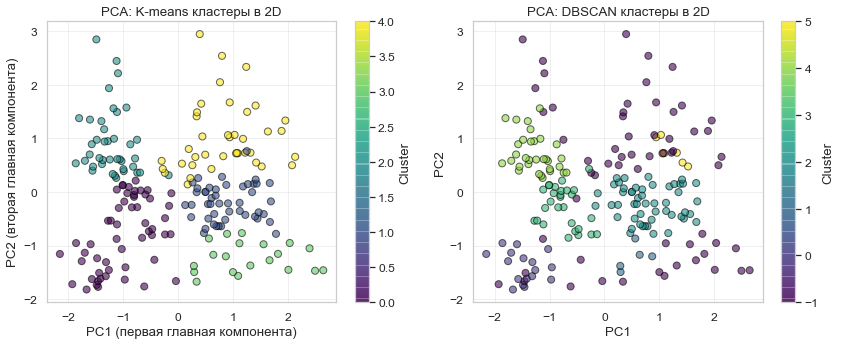

In [17]:
# PCA: проецируем 3D данные в 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA:")
print(f"  Explained variance: {pca.explained_variance_ratio_}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum()*100:.1f}% дисперсии объяснено 2 компонентами")

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_KMeans'], 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.xlabel('PC1 (первая главная компонента)')
plt.ylabel('PC2 (вторая главная компонента)')
plt.title('PCA: K-means кластеры в 2D')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_DBSCAN'], 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: DBSCAN кластеры в 2D')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

***Алгоритм t-SNE (t-distributed Stochastic Neighbor Embedding)***- это метод нелинейного снижения размерности, который используется для визуализации многомерных данных в 2D или 3D пространстве. Его главная цель — сохранить локальную структуру данных: близкие точки в исходном пространстве должны остаться близкими и на итоговой визуализации. 
Основные этапы работы

    Вычисление сходства в исходном пространстве:
    
    Для каждой пары точек рассчитывается вероятность того, что они являются «соседями». Чем ближе точки друг к другу, тем выше эта вероятность. Для этого используется нормальное (Гауссово) распределение, центрированное в каждой точке.
    
    Создание начальной карты:
    Все точки случайным образом размещаются в пространстве низкой размерности (например, на плоскости).
    
    Вычисление сходства в проекции:
    В низкоразмерном пространстве также рассчитываются вероятности соседства для всех пар точек. Однако здесь вместо Гауссова распределения используется t-распределение Стьюдента. Оно имеет более «тяжелые хвосты», что позволяет умеренно удаленным точкам располагаться на большем расстоянии друг от друга и решает проблему «скученности» (crowding problem).
   
   Оптимизация:
    Алгоритм итеративно перемещает точки в низкоразмерном пространстве так, чтобы распределение вероятностей в проекции стало максимально похожим на распределение в исходном пространстве. Для этого минимизируется расхождение Кульбака — Лейблера с помощью метода градиентного спуска. 

Ключевые параметры

    Perplexity (Сложность): Определяет баланс между сохранением локальной и глобальной структуры данных. Грубо говоря, это ожидаемое количество ближайших соседей для каждой точки. Обычно выбирается в диапазоне от 5 до 50.
    Learning Rate (Скорость обучения): Влияет на то, насколько сильно меняются позиции точек на каждой итерации оптимизации. 

Отличия от PCA
В отличие от PCA (метода главных компонент), который является линейным и стремится сохранить максимальную дисперсию (глобальную структуру), t-SNE — это нелинейный метод, который лучше справляется с выявлением сложных кластеров и закономерностей в данных

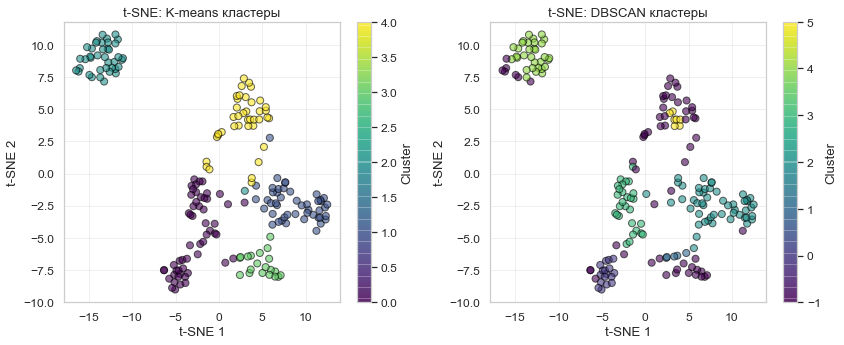

 PCA vs t-SNE:
• PCA: быстро, детерминировано, сохраняет глобальную структуру
• t-SNE: медленно, недетерминировано, сохраняет локальную структуру (лучше для кластеров)
• Для визуализации кластеров часто t-SNE лучше (кластеры компактнее)


In [18]:
# t-SNE: нелинейное снижение размерности (медленнее PCA)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster_KMeans'], 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: K-means кластеры')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster_DBSCAN'], 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: DBSCAN кластеры')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" PCA vs t-SNE:")
print("• PCA: быстро, детерминировано, сохраняет глобальную структуру")
print("• t-SNE: медленно, недетерминировано, сохраняет локальную структуру (лучше для кластеров)")
print("• Для визуализации кластеров часто t-SNE лучше (кластеры компактнее)")